# deCIFer: PCA Analysis of CIF and PXRD Data  

- Extracts structural, elemental, and volumetric features from CIF files  
- Computes PXRD embeddings and applies PCA for dimensionality reduction  
- Maps space groups to crystal systems for categorical analysis  
- Visualizes principal components with color-coded crystal systems, volume, and atomic properties  
- Saves figures for evaluating dataset structure and model embeddings  


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

from decifer.decifer_dataset import DeciferDataset
from decifer.decifer_model import Decifer, DeciferConfig
from decifer.tokenizer import Tokenizer
from bin.evaluate import extract_prompt, load_model_from_checkpoint
from decifer.utility import (
    replace_symmetry_loop_with_P1,
    extract_space_group_symbol,
    reinstate_symmetry_loop,
    discrete_to_continuous_xrd,
    generate_continuous_xrd_from_cif,
    space_group_symbol_to_number,
    extract_volume,
    extract_numeric_property,
    element_to_atomic_number,
    space_group_to_crystal_system,
)

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

In [98]:
# Initialize tokenizer and dataset
tokenizer = Tokenizer()
dataset = DeciferDataset('../data/crystallm/full/serialized/train.h5', ['cif_string', 'cif_tokens', 'xrd.q', 'xrd.iq', 'spacegroup', 'species'])

# Load model and set to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_model_from_checkpoint('../experiments/model__conditioned_mlp_augmentation__context_3076/ckpt.pt', device)
model.eval()
cond_embedder = model.transformer.cond_embedding

# Debug settings
debug_max = 500_000


number of total parameters: 26.14M


In [99]:
# Initialize storage lists
cif_strings, space_groups, avg_elements, max_elements, volumes, log_volumes, embeddings = [], [], [], [], [], [], []
sum_elements, cell_a, cell_b, cell_c, cell_alpha, cell_beta, cell_gamma = [], [], [], [], [], [], []

# Process dataset
pbar = tqdm(total=min(debug_max, len(dataset)) if debug_max else len(dataset))
for i, datum in enumerate(dataset):
    if debug_max and i >= debug_max:
        break

    # Extract data
    cif_string = datum['cif_string']
    space_group = space_group_symbol_to_number(datum['spacegroup'])
    volume = extract_volume(cif_string)
    log_volume = np.log10(volume)
    elements = [element_to_atomic_number(e) for e in datum['species'].split('"')[1::2]]
    avg_element, max_element, sum_element = np.mean(elements), np.max(elements), np.sum(elements)
    a, b, c = (extract_numeric_property(cif_string, f'_cell_length_{dim}') for dim in ['a', 'b', 'c'])
    alpha, beta, gamma = (extract_numeric_property(cif_string, f'_cell_angle_{angle}') for angle in ['alpha', 'beta', 'gamma'])

    # Simulate and embed XRD
    iq = discrete_to_continuous_xrd(
        datum['xrd.q'].unsqueeze(0),
        datum['xrd.iq'].unsqueeze(0),
        qmin=0.0,
        qmax=10.0,
        qstep=0.01,
        fwhm_range=(0.05, 0.05)
    )['iq'].squeeze(0).to(device)
    with torch.no_grad():
        embedding = cond_embedder(iq)

    # Append data
    cif_strings.append(cif_string)
    space_groups.append(space_group)
    avg_elements.append(avg_element)
    max_elements.append(max_element)
    sum_elements.append(sum_element)
    volumes.append(volume)
    cell_a.append(a)
    cell_b.append(b)
    cell_c.append(c)
    cell_alpha.append(alpha)
    cell_beta.append(beta)
    cell_gamma.append(gamma)
    log_volumes.append(log_volume)
    embeddings.append(embedding)
    pbar.update(1)
pbar.close()


  0%|          | 0/500000 [00:00<?, ?it/s]

In [103]:
# Convert lists to arrays
embeddings_stacked = torch.vstack(embeddings).cpu().numpy()
space_groups = np.array(space_groups, dtype=float)
avg_elements = np.array(avg_elements, dtype=float)
max_elements = np.array(max_elements, dtype=float)
sum_elements = np.array(sum_elements, dtype=float)
cell_a, cell_b, cell_c = np.array(cell_a), np.array(cell_b), np.array(cell_c)
cell_alpha, cell_beta, cell_gamma = np.array(cell_alpha), np.array(cell_beta), np.array(cell_gamma)
volumes, log_volumes = np.array(volumes), np.array(log_volumes)

# Apply PCA
pca = PCA(n_components=3)
pca_results = pca.fit_transform(embeddings_stacked)

In [104]:
df = pd.DataFrame({
    'PC1': pca_results[:, 0],
    'PC2': pca_results[:, 1],
    'PC3': pca_results[:, 2],
    'Spacegroup': space_groups,  # Ensure numeric values
    'Avg Element': avg_elements,
    'Max Element': max_elements,
    'Crystal System': [space_group_to_crystal_system(s) for s in space_groups],
    'Avg Element Spacegroup': space_groups.astype(float) + avg_elements,
    'Sum Element': sum_elements,
    'Volume': volumes,
    'Log Volume': log_volumes,
    'Cell A': cell_a,
    'Cell B': cell_b,
    'Cell C': cell_c,
    'Cell Alpha': cell_alpha,
    'Cell Beta': cell_beta,
    'Cell Gamma': cell_gamma,
})

# Define the mapping from numerical values to categorical names
crystal_system_mapping = {
    0: "Unknown",
    1: "Triclinic",
    2: "Monoclinic",
    3: "Orthorhombic",
    4: "Tetragonal",
    5: "Trigonal",
    6: "Hexagonal",
    7: "Cubic"
}

# Replace any 'Unknown' values or invalid mappings
df['Crystal System'] = df['Crystal System'].fillna(0)  # Assign '0' for unknown categories

# Ensure the 'Crystal System' column is numeric
df['Crystal System'] = df['Crystal System'].astype(int)  # Ensure integers

# Map the numerical values to names
df['Crystal System'] = df['Crystal System'].map(crystal_system_mapping)

# Convert the column to a categorical type
df['Crystal System'] = pd.Categorical(
    df['Crystal System'],
    categories=list(crystal_system_mapping.values()),
    ordered=True
)

# Map 'Crystal System' categories to numeric values for plotting
df['Crystal System Numeric'] = df['Crystal System'].cat.codes

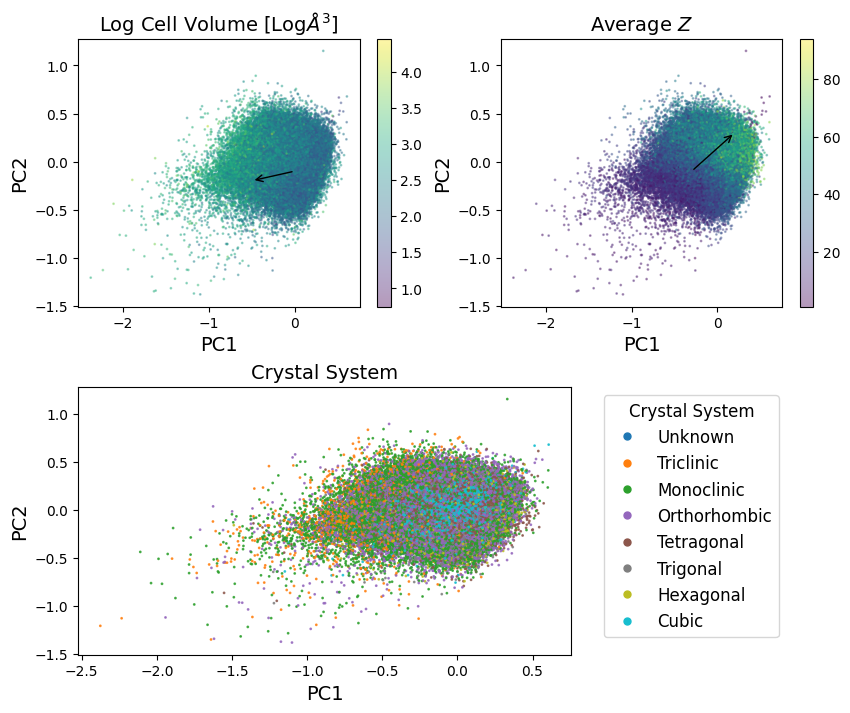

In [105]:
import matplotlib.colors as mcolors
# Set global font size
plt.rcParams.update({
    "font.size": 12,  # Global font size
    "axes.titlesize": 14,  # Axes title size
    "axes.labelsize": 14,  # Axes label size
    "xtick.labelsize": 10,  # X-axis tick labels
    "ytick.labelsize": 10,  # Y-axis tick labels
    "legend.fontsize": 12,  # Legend font size
})

# Define arrow coordinates for the subplots (start_x, start_y, end_x, end_y)
arrow_coords_bottom = [
    ((0.0, -0.1), (-0.5, -0.2)),  # Arrows for bottom-left subplot
    ((-0.3, -0.1), (0.2, 0.3))    # Arrows for bottom-right subplot
]

# Create a discrete colormap for the Crystal System
categories = df['Crystal System'].cat.categories
num_categories = len(categories)
discrete_cmap = plt.cm.get_cmap('tab10', num_categories)
norm = mcolors.BoundaryNorm(range(num_categories + 1), discrete_cmap.N)

# Update figure layout
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 6)  # 2 rows, 2 columns grid layout

# Top row: Full-width "Crystal System" subplot
ax1 = fig.add_subplot(gs[1, :4])  # Span both columns
scatter = ax1.scatter(
    df['PC1'], df['PC2'], c=df['Crystal System Numeric'], cmap=discrete_cmap, norm=norm, s=1, alpha=0.8
)
# Add a custom discrete legend for categories
handles = [
    plt.Line2D(
        [], [], marker="o", color=discrete_cmap(norm(idx)), linestyle="", markersize=5
    )
    for idx in range(num_categories)
]
ax1.legend(handles, categories, title="Crystal System", bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.set_title("Crystal System")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")

# Bottom row: Two subplots for "Log Volume" and "Average Z"
ax2 = fig.add_subplot(gs[0, :3])  # Bottom-left
scatter2 = ax2.scatter(
    df['PC1'], df['PC2'], c=df['Log Volume'], cmap='viridis', s=1, alpha=0.4
)
fig.colorbar(scatter2, ax=ax2)
ax2.set_title("Log Cell Volume [Log$Å^3$]")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")

# Add arrows to the bottom-left plot
for start, end in [arrow_coords_bottom[0]]:
    ax2.annotate(
        '', 
        xy=end, 
        xytext=start, 
        arrowprops=dict(facecolor='red', arrowstyle='->', lw=1)
    )

ax3 = fig.add_subplot(gs[0, 3:])  # Bottom-right
scatter3 = ax3.scatter(
    df['PC1'], df['PC2'], c=df['Avg Element'], cmap='viridis', s=1, alpha=0.4
)
fig.colorbar(scatter3, ax=ax3)
ax3.set_title("Average $Z$")
ax3.set_xlabel("PC1")
ax3.set_ylabel("PC2")

# Add arrows to the bottom-right plot
for start, end in [arrow_coords_bottom[1]]:
    ax3.annotate(
        '', 
        xy=end, 
        xytext=start, 
        arrowprops=dict(facecolor='red', arrowstyle='->', lw=1)
    )


# Adjust layout
fig.subplots_adjust(
    # top=0.9,    # Adjust top margin
    # bottom=0.1,  # Adjust bottom margin
    # left=0.1,    # Adjust left margin
    # right=0.9,   # Adjust right margin
    hspace=0.3,  # Adjust height (vertical) space between subplots
    wspace=1.0   # Adjust width (horizontal) space between subplots
)
plt.show()

fig.savefig("pca_train500k.png", transparent=True, bbox_inches='tight', dpi=300)
